# Imports

In [2]:
from abc import abstractmethod

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Functional

Функцию игры и Q-Agent'а честно берем из семинара.

In [3]:
class RiverSwim:
    def __init__(self, 
                 isc  = 4, # число состояний (без учета крайних)
                 ms   = 16, # максимальное число шагов
                 lr   = 5 / 1000, 
                 rr   = 1.0, 
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr
        
    @property
    def action_count(self):
        return 2
    
    @property
    def states_count(self):
        return 2 + self._interm_states
    
    def _get_probs(self, action): # 0 -- move left, 1 -- move right
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]
            
        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr
        
        self._steps += 1
        return self._current_state, reward, False

In [4]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        return self._q_matrix
        
    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return


А вот PosteriorSampling агента придется реализовывать уже самому. Самое главное -- правильно учесть размерности тензоров.

In [5]:
class PosteriorSamplingAgent:
    def __init__(self, n_states, n_actions, seed=56):
        self.rs = np.random.RandomState(seed)
        self.n_states = n_states
        self.n_actions = n_actions
        
        # Dirichlet parameters
        self._T = np.ones((n_states, n_states, n_actions)) # [initial_state, final_state, action]
        
        # GammaNormal parameters
        self._mu = np.ones((n_states, n_actions)) # [state, action]
        self._alpha = np.ones((n_states, n_actions)) # [state, action]
        self._beta = np.ones((n_states, n_actions)) # [state, action]
        self._nu = 0
        
        # V matrix. Start with zeros
        self._V = np.zeros(n_states, dtype=np.float32)
        
    def sample_S_matrix(self):
        S = np.zeros_like(self._T, dtype=np.float32)

        for in_state in range(self._T.shape[0]):
            for act in range(self._T.shape[-1]):
                S[in_state, :, act] = self.rs.dirichlet(self._T[in_state, :, act], size=1)

        return S
        
    def sample_R_matrix(self):
        tau = self.rs.gamma(self._alpha, self._beta)
        R = self.rs.normal(self._mu, 1 / np.sqrt(tau))

        return R
    
    def start_episode(self):
        self._S = self.sample_S_matrix()
        self._R = self.sample_R_matrix()
        
        # update V
        # V has shape [n_states] and only 1 axis
        # S has shape [initial_state, final_state, action] and 3 axes
        # so, we need zero (and only) axis in v and 1st axis in S
        self._V = np.max(self._R + np.tensordot(self._V, self._S, axes=[[0], [1]]), axis=-1)
        
    
    def get_action(self, state):
        act = np.argmax(self._R[state] + np.dot(self._V, self._S[state]))
        
        return act


    def update(self, state, action, reward, next_state):
        
        # update T -- "transition probability"
        self._T[state, next_state, action] += 1
        
        # update mu, alpha, beta -- reward params
        self._alpha[state, action] += 1 / 2
        
        # update beta before mu -- because it's used to compute it
        self._beta[state, action] += self._nu / (self._nu + 1) * (reward - self._mu[state, action]) ** 2 / 2
        
        # and finally, update the mu
        self._mu[state, action] = (self._nu * self._mu[state, action] + reward) / (self._nu + 1)
        
        # do not forger about nu
        self._nu += 1
        
    def get_state_action_exp_reward(self):
        return self._R + np.tensordot(self._V, self._S, axes=[[0], [1]])

In [6]:
# Tests

# T_matrix

# test 1
ag = PosteriorSamplingAgent(3, 5)

S_1 = ag.sample_S_matrix()

assert S_1.shape == (3, 3, 5)
assert np.allclose(S_1.sum(axis=1), 1)


# test 2

ag._T = np.random.randint(1, 10, size=ag._T.shape)

S_2 = ag.sample_S_matrix()

assert S_2.shape == (3, 3, 5)
assert np.allclose(S_2.sum(axis=1), 1)
assert not np.allclose(S_2, S_1)

In [7]:
# R matrix

ag = PosteriorSamplingAgent(3, 4)
R_1 = ag.sample_R_matrix()

assert R_1.shape == (3, 4)

In [8]:
s = np.random.randn(3, 4, 5)
v = np.random.randn(4)

a_1 = np.tensordot(v, s, axes=[[0], [1]])

a_2 = np.zeros((3, 5))
for i in range(3):
    for j in range(5):
        a_2[i, j] = np.dot(v, s[i, :, j])
        
assert a_1.shape == a_2.shape
assert np.allclose(a_1, a_2)

In [9]:
# initialize new ep

# ag = PosteriorSamplingAgent(3, 4)
# for ep in range(3):
#     ag.initialize_new_ep()
#     print("==========")
#     print(ag._S, ag._V, ag._R)

In [25]:
# get action 

ag = PosteriorSamplingAgent(3, 4)

for state in range(3):
    ag.start_episode()
    ans_ = np.argmax(ag._R[state] + np.dot(ag._V, ag._S[state]))
    ans = ag.get_action(state)

    assert ans == ans_

In [ ]:
# update

ag = PosteriorSamplingAgent(3, 4)
ag.initialize_new_ep()

ag.update(0, 1, 0.3, 2)
ag

# ag._T, ag._alpha, ag._beta, ag._mu

ag.update(0, 1, 0.3, 2)


# ag._T, ag._alpha, ag._beta, ag._mu, ag._nu

# Experiment

Сравним работу обычного Q-Learning и Posterior Sampling на той задаче, которую они могут оба решить.

**Примечание:** аналогом Q-матрицы у PosteriorSampling агента является выражение

$$E_{ia} = R_{ia} + V_f \cdot S_{ifa}$$

По сути, это ожидаемая награда для пары (состояние, действие). То есть если мы будем действовать оптимально далее, мы можем получить столько. Это, конечно, не совсем строго, но интуиция здесь такая. Для наглядности я также решил выводить матрицу $R$.

## 2.1, n_states = 4

In [37]:
n_intermediate_steps = 2
ms = 200
episodes = 500
actions = 2

ps_agent = PosteriorSamplingAgent(n_intermediate_steps + 2, actions)
q_agent = QLearningAgent(2 + n_intermediate_steps, actions)

def train_agent(agent):
    episode_rewards = []
    for ep in tqdm(range(episodes)):
        river_swim = RiverSwim(n_intermediate_steps, ms)

        state, ep_reward, is_done = river_swim._current_state, 0.0, False
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)
            next_state, reward, is_done = river_swim.step(action)
            agent.update(state, action, reward, next_state)

            state = next_state
            ep_reward += reward

        episode_rewards.append(ep_reward)
    
    return episode_rewards


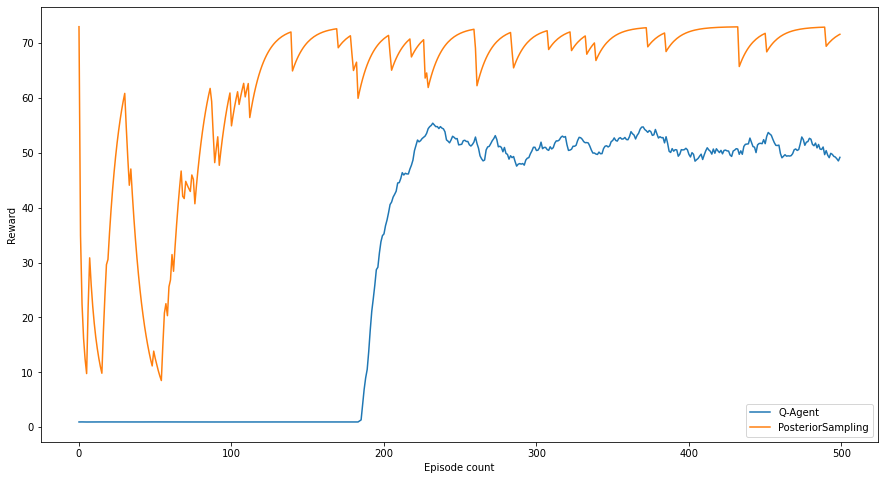

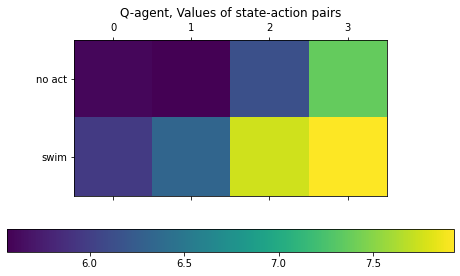

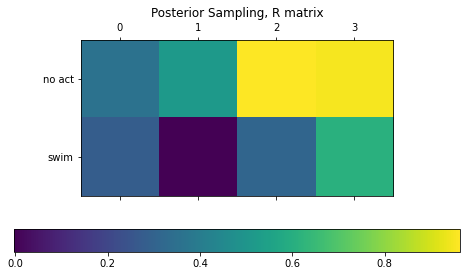

Text(0.5, 1.0, 'Posterior Sampling, expectation of reward')

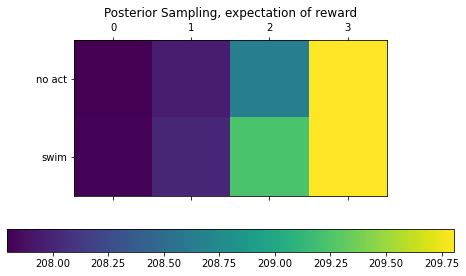

In [38]:
q_hist = train_agent(q_agent)
ps_hist = train_agent(ps_agent)

        
plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(q_hist)).ewm(alpha=.1).mean(), label='Q-Agent')
plt.plot(pd.DataFrame(np.array(ps_hist)).ewm(alpha=.1).mean(), label='PosteriorSampling')

# plt.plot(np.array(q_hist), label='Q-Agent')
# plt.plot(np.array(ps_hist), label='PosteriorSampling')

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.legend()
plt.show()


msh = plt.matshow(q_agent.get_q_matrix().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Q-agent, Values of state-action pairs")
plt.show()


msh = plt.matshow(ps_agent._R.T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Posterior Sampling, R matrix")

plt.show()

msh = plt.matshow(ps_agent.get_state_action_exp_reward().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Posterior Sampling, expectation of reward")


**Вывод:** как видно, оба справились с задачей. При этом нельзя не отметить несколько важных моментов:
1. PosteriorSamplig сошелся быстрее;
2. Средняя награда у PosteriorSampling была выше;
3. Если сравнить матрицы $R$ и $E$, то получится, что чем выше по течению реки, тем менее выгодно с точки зрения $R$ плыть дальше. Однако, с точки зрения $E$ агент должен стремиться к крайнему правому состоянию. Это логично: мы не получаем никаких наград в правых клетках (кроме самой правой, конечно), поэтому $R$ и дает им малый вес. Однако  ожидаемая награда получается выше как раз если мы боремся с течением, так что у матрицы $E$ большие веса в соответствующих элементах.

## 2.2, n_states = 6

In [19]:
n_intermediate_steps = 4
ms = 200
episodes = 500
actions = 2

ps_agent = PosteriorSamplingAgent(n_intermediate_steps + 2, actions)
q_agent = QLearningAgent(2 + n_intermediate_steps, actions)

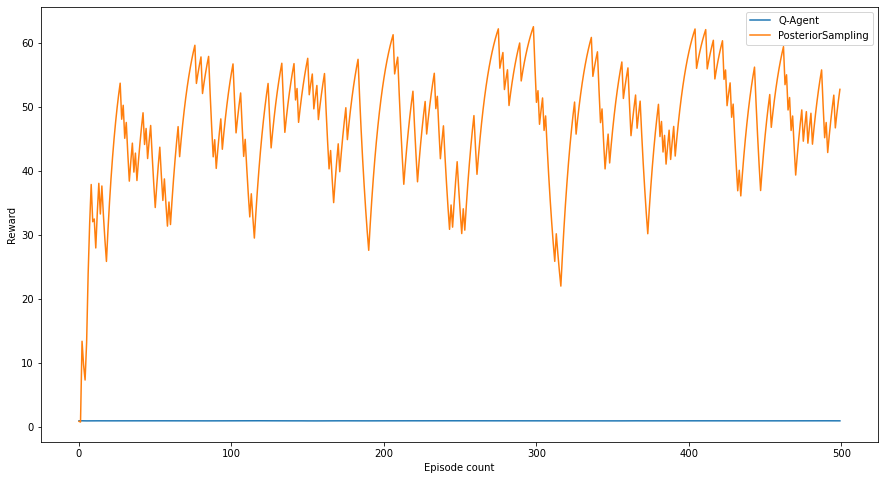

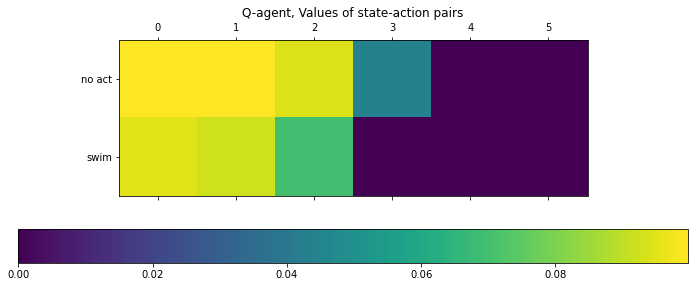

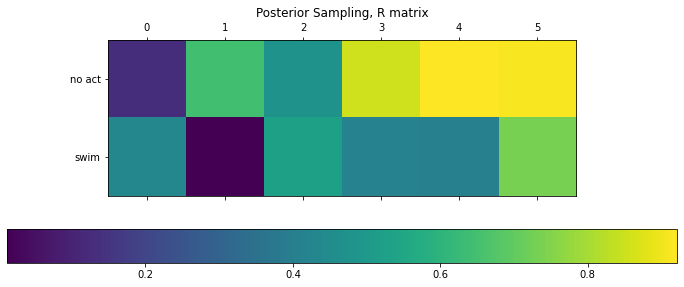

Text(0.5, 1.0, 'Posterior Sampling, expectation of reward')

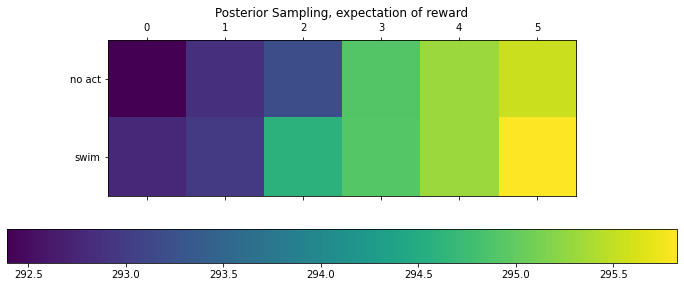

In [20]:
q_hist = train_agent(q_agent)
ps_hist = train_agent(ps_agent)

        
plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(q_hist)).ewm(alpha=.1).mean(), label='Q-Agent')
plt.plot(pd.DataFrame(np.array(ps_hist)).ewm(alpha=.1).mean(), label='PosteriorSampling')

# plt.plot(np.array(q_hist), label='Q-Agent')
# plt.plot(np.array(ps_hist), label='PosteriorSampling')

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.legend()
plt.show()


msh = plt.matshow(q_agent.get_q_matrix().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Q-agent, Values of state-action pairs")
plt.show()


msh = plt.matshow(ps_agent._R.T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Posterior Sampling, R matrix")

plt.show()

msh = plt.matshow(ps_agent.get_state_action_exp_reward().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Posterior Sampling, expectation of reward")


**Вывод:** в данном случае у Q-Agent'а даже не получилось обучиться доходить до правого конца, в то время как PS-агент с этим успешно справился. Также сохранился схожий с предыдущим пунктом синдром для матриц $R$ и $E$.

## 2.3, n_states = 15

In [35]:
n_intermediate_steps = 13
ms = 400
episodes = 1000
actions = 2

ps_agent = PosteriorSamplingAgent(n_intermediate_steps + 2, actions)
q_agent = QLearningAgent(2 + n_intermediate_steps, actions)

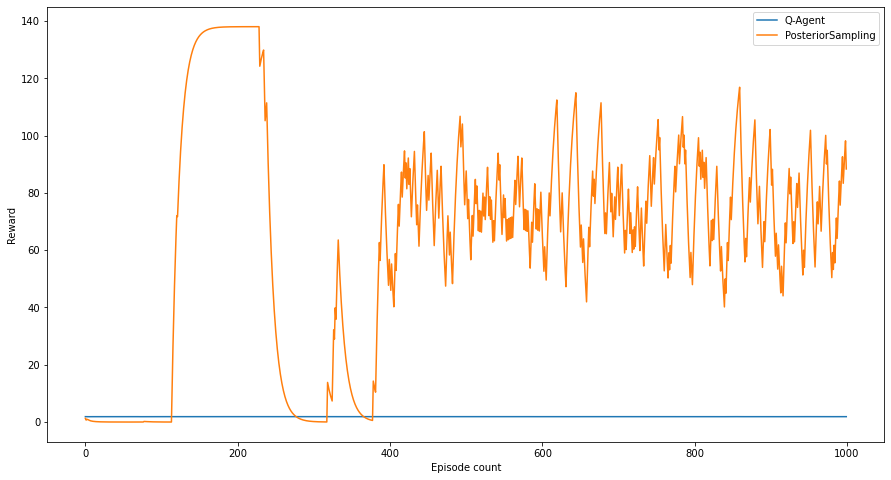

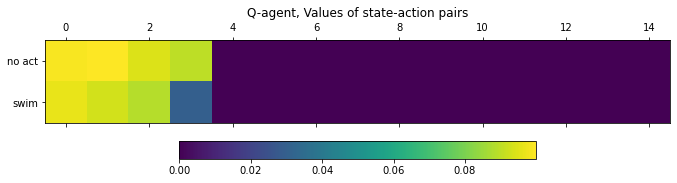

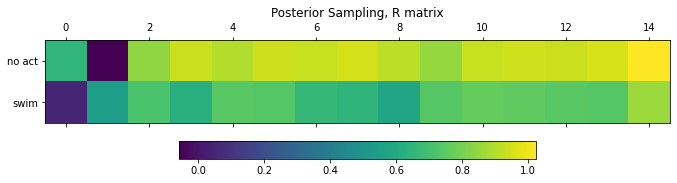

Text(0.5, 1.0, 'Posterior Sampling, expectation of reward')

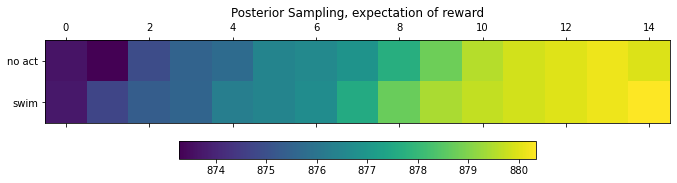

In [36]:
q_hist = train_agent(q_agent)
ps_hist = train_agent(ps_agent)

        
plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(q_hist)).ewm(alpha=.1).mean(), label='Q-Agent')
plt.plot(pd.DataFrame(np.array(ps_hist)).ewm(alpha=.1).mean(), label='PosteriorSampling')

# plt.plot(np.array(q_hist), label='Q-Agent')
# plt.plot(np.array(ps_hist), label='PosteriorSampling')

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.legend()
plt.show()


msh = plt.matshow(q_agent.get_q_matrix().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Q-agent, Values of state-action pairs")
plt.show()


msh = plt.matshow(ps_agent._R.T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Posterior Sampling, R matrix")

plt.show()

msh = plt.matshow(ps_agent.get_state_action_exp_reward().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Posterior Sampling, expectation of reward")


**Вывод**:Как видно, PS агент успешно справился и с этой задачей. Однако нельзя не отметить, что это заняло у него существенно больше времени, чем в случае n = 6. Также увеличился разброс  и были выбросы в течение процесса обучения, что свидетельствует об усложнении задачи.

Также стоит отметить, что судя по матрице $E$, алгоритм уже не столь уверен в правильности выбора "плыть вправо". Это может быть результатом недостаточно долгого обучения, а может он уже не считает целесообразным проделывать столь долгий путь, чтобы получить бОльшую награду.

## 2.4, n_states = 42

In [33]:
n_intermediate_steps = 40
ms = 3300
episodes = 3300
actions = 2

ps_agent = PosteriorSamplingAgent(n_intermediate_steps + 2, actions)
q_agent = QLearningAgent(2 + n_intermediate_steps, actions)

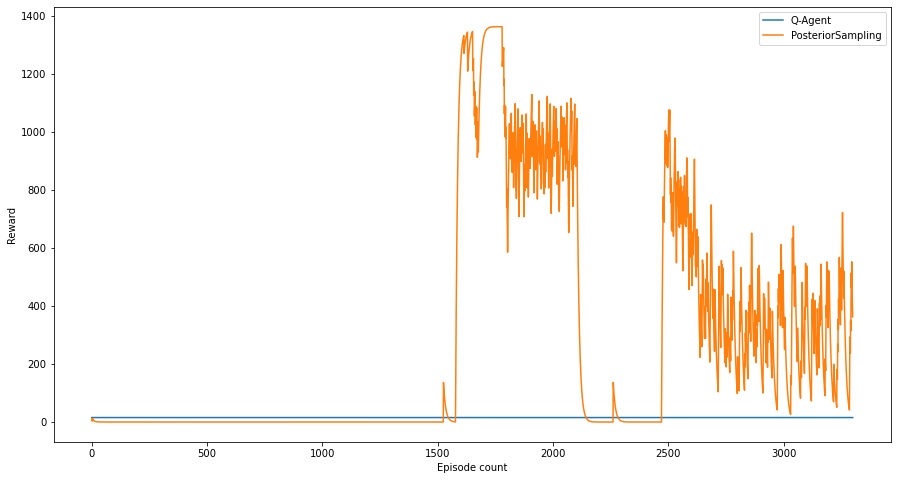

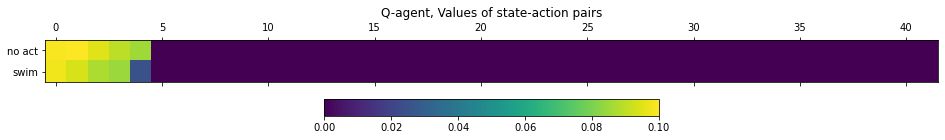

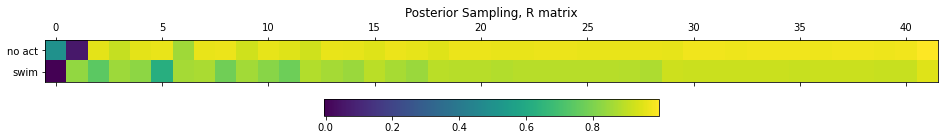

Text(0.5, 1.0, 'Posterior Sampling, expectation of reward')

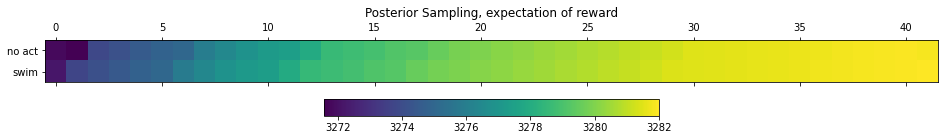

In [34]:
q_hist = train_agent(q_agent)
ps_hist = train_agent(ps_agent)

        
plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(q_hist)).ewm(alpha=.1).mean(), label='Q-Agent')
plt.plot(pd.DataFrame(np.array(ps_hist)).ewm(alpha=.1).mean(), label='PosteriorSampling')

# plt.plot(np.array(q_hist), label='Q-Agent')
# plt.plot(np.array(ps_hist), label='PosteriorSampling')

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.legend()
plt.show()


msh = plt.matshow(q_agent.get_q_matrix().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Q-agent, Values of state-action pairs")
plt.show()


msh = plt.matshow(ps_agent._R.T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Posterior Sampling, R matrix")

plt.show()

msh = plt.matshow(ps_agent.get_state_action_exp_reward().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.title("Posterior Sampling, expectation of reward")


**Вывод**: тут уже пришлось существенно увеличивать число игр и их продолжительность, так как даже PS-agent не успевал обучиться. Также хочется заметить, что были существенные выбросы и разброс ещё увеличися, однако это также связано с увеличенным временем одного эпизода.

Однако в целом даже для столь протяженной реки алгоритм справился с задачей, хотя, как видно из $R$ и $E$ матриц, он по во многом остался неуверенным в своих предсказаниях.